<h1 align="center"><font size="5">DESCRIPTION OF THE PROBLEM AND BACKGROUND</font></h1> 

A client is looking to open a coffee shop serving gourmet tea, coffee and desserts in the Greater Toronto Area (GTA).  She needs some recommendations on where to open her business.  Given the exquisite quality of food and drinks served and to cover the costs, she is looking for an affluent neighbourhood where people are willing to splurge.  The population targeted is also the younger age group under 40 years old who tends to value such lifestyle and experience.   The client is aware of potential competitions.  Therefore, she expects to pick a location that has less competition allowing her to build the client base at the beginning.  There are over 100 neighbourhoods in the GTA and she wonders which areas are worth looking at so she can conduct further analysis before deciding on a location.  

<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#ref1">Acquiring the Data and Pre-Processing</a></li>
        <li><a href="#ref2">Modelling</a></li>
        <li><a href="#ref3">Results</a></li>
        <li><a href="#ref3">Dicussions</a></li>
        <li><a href="#ref3">Conclusions</a></li>
    </ol>
</div>
<br>
<hr>

In [1]:
# import libriaries
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


# 1. Acquiring the Data and Pre-Processing

In [2]:
# Read income csv file from CRA website
!wget -O population.csv https://www.canada.ca/content/dam/cra-arc/prog-policy/stats/individual-tax-stats-fsa/2015-tax-year/tbl1a-en.csv

--2019-04-25 16:49:56--  https://www.canada.ca/content/dam/cra-arc/prog-policy/stats/individual-tax-stats-fsa/2015-tax-year/tbl1a-en.csv
Resolving www.canada.ca (www.canada.ca)... 104.93.181.68, 2600:140a:0:3a5::fe9, 2600:140a:0:3a0::fe9, ...
Connecting to www.canada.ca (www.canada.ca)|104.93.181.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘population.csv’

population.csv          [ <=>                ] 117.33K  --.-KB/s    in 0.003s  

2019-04-25 16:49:58 (33.6 MB/s) - ‘population.csv’ saved [120145]



## a) Income data

In [3]:
# Load file into datafrome, drop unnecesssary columns and rows with NA
pop_df = pd.read_csv("population.csv")
pop_df.drop(pop_df.columns[[6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]],axis=1,inplace=True)
pop_df.dropna(axis=0, inplace=True)
pop_df.head()

,Prov/Terr,FSA,Total,Total Income,Net Income,Taxable Income
0,10,A0A,40150.0,1.673931e+09,1.567848e+09,1.493232e+09
1,10,A0B,17820.0,7.141520e+08,6.711270e+08,6.387630e+08
2,10,A0C,11180.0,3.787120e+08,3.585890e+08,3.375470e+08
3,10,A0E,19860.0,8.285010e+08,7.723290e+08,7.383670e+08
4,10,A0G,31290.0,1.089500e+09,1.023297e+09,9.636890e+08


In [4]:
# Drop rows not Toronto
torpop_df = pop_df[pop_df['FSA'].str.match('M')]
torpop_df.head()

,Prov/Terr,FSA,Total,Total Income,Net Income,Taxable Income
906,35,M1B,51410.0,1.577233e+09,1.476645e+09,1.395635e+09
907,35,M1C,29080.0,1.483624e+09,1.344497e+09,1.313105e+09
908,35,M1E,36220.0,1.320927e+09,1.220781e+09,1.156938e+09
909,35,M1G,22820.0,6.372060e+08,5.978630e+08,5.540320e+08
910,35,M1H,19440.0,6.152230e+08,5.736890e+08,5.461960e+08


In [5]:
# Drop other income columns and rename Total to Population
torpop1 = torpop_df.drop(['Prov/Terr','Net Income','Taxable Income'],axis=1)
torpop1.rename(index=str, columns={"Total":"Population"}, inplace=True)


In [6]:
# Calculate Average income using Total Income divided by Population
torpop1['Average Income'] = torpop1['Total Income'] / torpop1['Population']
torpop1.sort_values(by='Average Income', ascending=False, inplace=True)
torpop1.dropna(axis=0)
torpop1.rename(columns={"FSA":"PostalCode"},inplace=True)
torpop2 = torpop1.drop(['Total Income','Population'],axis=1)
torpop2.head()

,PostalCode,Average Income
976,M5X,386127.272727
967,M5L,237900.000000
950,M4N,211828.785358
956,M4W,202622.068966
954,M4T,183044.696970


## b) Age data

In [7]:
# Read age csv file from CRA website
!wget -O age.csv https://www.canada.ca/content/dam/cra-arc/prog-policy/stats/individual-tax-stats-fsa/2015-tax-year/tbl2-en.csv

--2019-04-25 16:49:58--  https://www.canada.ca/content/dam/cra-arc/prog-policy/stats/individual-tax-stats-fsa/2015-tax-year/tbl2-en.csv
Resolving www.canada.ca (www.canada.ca)... 104.93.181.68, 2600:140a:0:3a1::fe9, 2600:140a:0:3a0::fe9, ...
Connecting to www.canada.ca (www.canada.ca)|104.93.181.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘age.csv’

age.csv                 [ <=>                ] 178.69K  --.-KB/s    in 0.004s  

2019-04-25 16:49:58 (47.5 MB/s) - ‘age.csv’ saved [182983]



In [8]:
# Load file into datafrome, drop unnecesssary columns and rows with NA
age_df = pd.read_csv("age.csv")
age_df.drop(age_df.columns[[17,18,19,20,21,22,23,24]],axis=1,inplace=True)
age_df.dropna(axis=0, inplace=True)
age_df.head()

,Prov/Terr,FSA,Total,Total Income,Under 20,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,Over 75
0,10,A0A,40150.0,1.673931e+09,1500.0,2320.0,2350.0,2620.0,2780.0,3140.0,3470.0,3920.0,4130.0,4140.0,3870.0,2520.0,3410.0
1,10,A0B,17820.0,7.141520e+08,660.0,990.0,850.0,850.0,870.0,1090.0,1410.0,1710.0,1980.0,2130.0,1990.0,1390.0,1910.0
2,10,A0C,11180.0,3.787120e+08,340.0,560.0,480.0,560.0,580.0,780.0,970.0,1140.0,1270.0,1280.0,1190.0,780.0,1260.0
3,10,A0E,19860.0,8.285010e+08,720.0,1130.0,990.0,1060.0,1180.0,1480.0,1770.0,1970.0,2020.0,2220.0,2120.0,1300.0,1920.0
4,10,A0G,31290.0,1.089500e+09,940.0,1530.0,1370.0,1450.0,1850.0,2270.0,2670.0,3010.0,3230.0,3630.0,3410.0,2380.0,3550.0


In [9]:
# Drop rows not Toronto
torage_df = age_df[age_df['FSA'].str.match('M')]
torage_df.head()

,Prov/Terr,FSA,Total,Total Income,Under 20,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,Over 75
906,35,M1B,51410.0,1.577233e+09,2140.0,4990.0,4870.0,4460.0,4000.0,4170.0,4320.0,4840.0,4370.0,4010.0,3530.0,2360.0,3350.0
907,35,M1C,29080.0,1.483624e+09,1210.0,2660.0,2300.0,1990.0,2010.0,1910.0,2330.0,2850.0,2870.0,2560.0,2270.0,1650.0,2470.0
908,35,M1E,36220.0,1.320927e+09,1380.0,3360.0,3000.0,2660.0,2490.0,2610.0,3140.0,3490.0,3350.0,2810.0,2260.0,1780.0,3910.0
909,35,M1G,22820.0,6.372060e+08,950.0,2360.0,2230.0,1890.0,1830.0,1790.0,1960.0,2010.0,1860.0,1460.0,1290.0,990.0,2200.0
910,35,M1H,19440.0,6.152230e+08,660.0,1990.0,2050.0,1880.0,1680.0,1510.0,1650.0,1640.0,1530.0,1250.0,960.0,800.0,1840.0


In [10]:
# Drop other income columns and rename Total to Population
torage1 = torage_df.drop(['Prov/Terr','Total Income'],axis=1)
torage1.rename(index=str, columns={"Total":"Population"}, inplace=True)
torage1.head()

,FSA,Population,Under 20,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,Over 75
906,M1B,51410.0,2140.0,4990.0,4870.0,4460.0,4000.0,4170.0,4320.0,4840.0,4370.0,4010.0,3530.0,2360.0,3350.0
907,M1C,29080.0,1210.0,2660.0,2300.0,1990.0,2010.0,1910.0,2330.0,2850.0,2870.0,2560.0,2270.0,1650.0,2470.0
908,M1E,36220.0,1380.0,3360.0,3000.0,2660.0,2490.0,2610.0,3140.0,3490.0,3350.0,2810.0,2260.0,1780.0,3910.0
909,M1G,22820.0,950.0,2360.0,2230.0,1890.0,1830.0,1790.0,1960.0,2010.0,1860.0,1460.0,1290.0,990.0,2200.0
910,M1H,19440.0,660.0,1990.0,2050.0,1880.0,1680.0,1510.0,1650.0,1640.0,1530.0,1250.0,960.0,800.0,1840.0


In [11]:
# Calculate Population under 40 by adding up relevant age group columns
torage1['Population under 40'] = torage1['Under 20']+torage1['20-24']+torage1['25-29']+torage1['30-34']+torage1['35-39']
torage1.sort_values(by='Population under 40', ascending=False, inplace=True)
torage1.dropna(axis=0)
torage1.rename(columns={"FSA":"PostalCode"},inplace=True)
torage1.head()

,PostalCode,Population,Under 20,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,Over 75,Population under 40
928,M2N,71020.0,1700.0,5740.0,8540.0,8790.0,7570.0,6850.0,6360.0,5920.0,4780.0,3980.0,3360.0,2280.0,5170.0,32340.0
974,M5V,35020.0,370.0,2900.0,8160.0,7790.0,4470.0,2780.0,1870.0,1730.0,1440.0,1050.0,890.0,570.0,1020.0,23690.0
906,M1B,51410.0,2140.0,4990.0,4870.0,4460.0,4000.0,4170.0,4320.0,4840.0,4370.0,4010.0,3530.0,2360.0,3350.0,20460.0
924,M2J,47680.0,1460.0,4220.0,4930.0,4580.0,4200.0,4200.0,4160.0,4130.0,3450.0,2940.0,2780.0,2110.0,4510.0,19390.0
1006,M9V,43220.0,1950.0,4580.0,4310.0,3950.0,3660.0,3760.0,3980.0,3890.0,3430.0,2670.0,2340.0,1690.0,3010.0,18450.0


In [12]:
# Remove age group columns
torage2 = torage1.drop(['Population','Under 20','20-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-64','65-69','70-74','Over 75'],axis=1)
torage2.head()

,PostalCode,Population under 40
928,M2N,32340.0
974,M5V,23690.0
906,M1B,20460.0
924,M2J,19390.0
1006,M9V,18450.0


## c) Neighbourhood names data


In [13]:
# read neighbourhood names from wiki page
request = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
df  = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M',header=0)[0]
df.rename(columns = {'Postcode':'PostalCode'},inplace=True)

In [14]:
#Remove rows with Borough equal not assigned
df.drop(df[df.Borough == 'Not assigned'].index, inplace=True)
df.shape


(211, 3)

In [15]:
#Put multiple neighbourhoods into one row if the same Postcode
hood_df = df.groupby(['PostalCode', 'Borough'], as_index=False, sort=False).agg(', '.join)
hood_df.head()


,PostalCode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront, Regent Park"
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park,Not assigned


In [16]:
# assign neighbourhood for Queen's Park being Queen's Park
hood_df.loc[hood_df['Neighbourhood'] =="Not assigned", 'Neighbourhood'] = hood_df.Borough
hood_df.loc[hood_df['PostalCode'] == "M7A"]


,PostalCode,Borough,Neighbourhood
4,M7A,Queen's Park,Queen's Park


## d) Geospatial data

In [17]:
# Read geospatial data

path='http://cocl.us/Geospatial_data'
latlon = pd.read_csv(path)
latlon.head()


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [18]:
latlon.rename(columns = {'Postal Code':'PostalCode'},inplace=True)

In [19]:
# neighbourhood names with geospatial data
Mcode_table = hood_df.join(latlon.set_index('PostalCode'), on='PostalCode')
Mcode_table.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


#### *Start merging data into one dataframe*

In [24]:
# add Average Income data
Merge_table = Mcode_table.join(torpop2.set_index('PostalCode'), on='PostalCode')
Merge_table.dropna(axis=0,inplace=True)
Merge_table.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Average Income
0,M3A,North York,Parkwoods,43.753259,-79.329656,44054.978854
1,M4A,North York,Victoria Village,43.725882,-79.315572,38352.228164
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636,50511.195010
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763,40898.576052
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242,85128.789492


In [127]:
# add Popultion under 40 data
Merge_table1 = Merge_table.join(torage2.set_index('PostalCode'), on='PostalCode')
Merge_table1.dropna(axis=0,inplace=True)
Merge_table1.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Average Income,Population under 40
0,M3A,North York,Parkwoods,43.753259,-79.329656,44054.978854,9610.0
1,M4A,North York,Victoria Village,43.725882,-79.315572,38352.228164,3840.0
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636,50511.195010,14020.0
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763,40898.576052,5900.0
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242,85128.789492,10020.0


In [26]:
# Use Average Income and Population under 40 data for k-means modelling
df_for_X = Merge_table1[['Average Income','Population under 40']]
df_for_X.head()

,Average Income,Population under 40
0,44054.978854,9610.0
1,38352.228164,3840.0
2,50511.195010,14020.0
3,40898.576052,5900.0
5,85128.789492,10020.0


#### *Exploratory Data Analysis*

In [27]:
## Perform descriptive statistics
df_for_X.describe()

,Average Income,Population under 40
count,100.000000,100.000000
mean,69670.632177,8449.900000
std,56692.724747,5167.320681
min,23701.218583,10.000000
25%,33864.392065,5117.500000
50%,49423.920949,7835.000000
75%,77482.160426,11017.500000
max,386127.272727,32340.000000


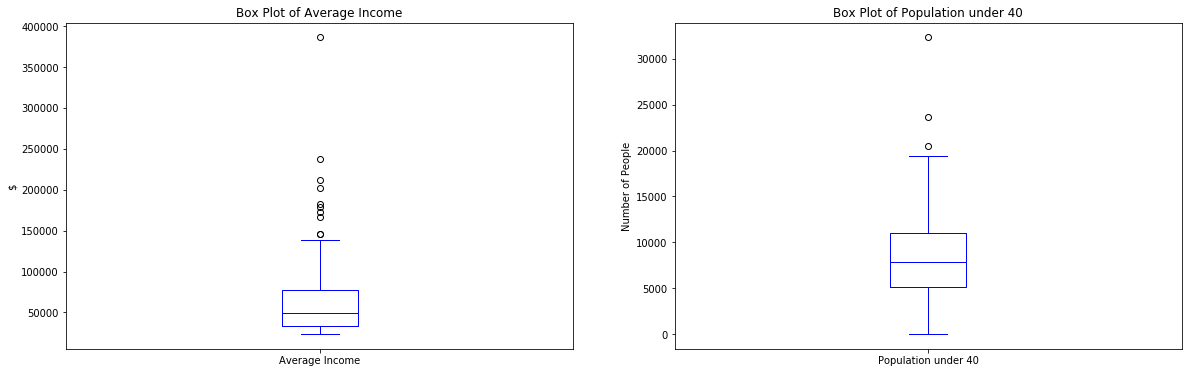

In [31]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

%matplotlib inline

df_for_Income = df_for_X['Average Income']
df_for_Pop40 = df_for_X['Population under 40']

fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot). 

# Subplot 1:
df_for_Income.plot(kind='box', color='blue', vert=True, figsize=(20, 6), ax=ax0) # add to subplot 1
ax0.set_title('Box Plot of Average Income')
ax0.set_xlabel('')
ax0.set_ylabel('$')

# Subplot 2:
df_for_Pop40.plot(kind='box', color='blue', vert=True, figsize=(20, 6), ax=ax1) # add to subplot 2
ax1.set_title ('Box Plot of Population under 40')
ax1.set_ylabel('Number of People')
ax1.set_xlabel('')

plt.show()

## e) Existing venues data

In [32]:
# Load in Foursquare credentials
CLIENT_ID = 'L2CUVSANXEREEWGA5FKH1MSSIRRGC0451DZEM21TOVDQNPNU' # your Foursquare ID
CLIENT_SECRET = 'NA0FFIZP4E530R4CPNLO1NOUJ5JXUCIV3TKGW4T2TYS2N52L' # your Foursquare Secret
VERSION = '20190424' # Foursquare API version


In [33]:
# define function to get nearby venues 

LIMIT = 100 # limit of number of venues returned by Foursquare
radius = 500 # define radius
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [34]:
Toronto_venues = getNearbyVenues(names=Merge_table1['Neighbourhood'],
                                   latitudes=Merge_table1['Latitude'],
                                   longitudes=Merge_table1['Longitude']
                                  )

Parkwoods
Victoria Village
Harbourfront, Regent Park
Lawrence Heights, Lawrence Manor
Islington Avenue
Rouge, Malvern
Don Mills North
Woodbine Gardens, Parkview Hill
Ryerson, Garden District
Glencairn
Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park
Highland Creek, Rouge Hill, Port Union
Flemingdon Park, Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Downsview North, Wilson Heights
Thorncliffe Park
Adelaide, King, Richmond
Dovercourt Village, Dufferin
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto
Harbourfront East, Toronto Islands, Union Station
Little Portugal, Trinity
East Birchmount Park, Ionview, Kennedy Park
Bayview Village
CFB Toronto, Downsview East
The Danforth West,

In [35]:
print(Toronto_venues.shape)
Toronto_venues.head()

(2181, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [36]:
Toronto_venues["Venue Category"].unique()


array(['Park', 'Fast Food Restaurant', 'Food & Drink Shop',
       'Hockey Arena', 'Coffee Shop', 'Portuguese Restaurant',
       'Intersection', 'Bakery', 'Gym / Fitness Center', 'Breakfast Spot',
       'Spa', 'Restaurant', 'Pub', 'Historic Site', 'Chocolate Shop',
       'Farmers Market', 'Dessert Shop', 'Performing Arts Venue',
       'Mexican Restaurant', 'Café', 'French Restaurant', 'Yoga Studio',
       'Event Space', 'Theater', 'Italian Restaurant', 'Shoe Store',
       'Brewery', 'Art Gallery', 'Electronics Store', 'Beer Store',
       'Bank', 'Hotel', 'Health Food Store', 'Antique Shop', 'Boutique',
       'Vietnamese Restaurant', 'Furniture / Home Store',
       'Clothing Store', 'Accessories Store', "Women's Store",
       'Arts & Crafts Store', 'Miscellaneous Shop', 'Gift Shop',
       'Caribbean Restaurant', 'Japanese Restaurant', 'Baseball Field',
       'Basketball Court', 'Gastropub', 'Rock Climbing Spot', 'Pharmacy',
       'Pizza Place', 'Pet Store', 'Athletics & Spo

In [37]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighbourhood'] = Toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()


,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Rock Climbing Spot,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [38]:
Coffeevenue = Toronto_onehot[['Neighbourhood','Coffee Shop','Chocolate Shop','Dessert Shop','Café']]
Coffeevenue_agg = Coffeevenue.groupby('Neighbourhood', as_index=False).agg({"Coffee Shop": "sum","Chocolate Shop":"sum","Dessert Shop":"sum","Café":"sum"})
Coffeevenue_agg['Number of Coffee Venues'] = Coffeevenue_agg['Coffee Shop'] + Coffeevenue_agg['Chocolate Shop'] + Coffeevenue_agg['Dessert Shop'] + Coffeevenue_agg['Café']
Coffeevenue_agg

,Neighbourhood,Coffee Shop,Chocolate Shop,Dessert Shop,Café,Number of Coffee Venues
0,"Adelaide, King, Richmond",6,0,0,5,11
1,Agincourt,0,0,0,0,0
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0,0,0,0,0
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0,0,0,0,0
4,"Alderwood, Long Branch",1,0,0,0,1
5,"Bathurst Manor, Downsview North, Wilson Heights",2,0,0,0,2
6,Bayview Village,0,0,0,1,1
7,"Bedford Park, Lawrence Manor East",2,0,0,1,3
8,Berczy Park,5,0,0,2,7
9,"Birch Cliff, Cliffside West",0,0,0,1,1


## Pre-Processing

In [90]:
# Normalize over the standard deviation
from sklearn.preprocessing import StandardScaler
X = df_for_X.values[:,]
Clus_dataSet = StandardScaler().fit_transform(X)


array([[-4.54109418e-01,  2.25638090e-01],
       [-5.55206695e-01, -8.96620146e-01],
       [-3.39654849e-01,  1.08337792e+00],
       [-5.10065525e-01, -4.95952561e-01],
       [ 2.74039266e-01,  3.05382610e-01],
       [-6.91227390e-01,  2.33595037e+00],
       [ 9.73641217e-01, -9.56914783e-01],
       [-4.54225382e-01, -6.82671436e-01],
       [-4.17475660e-01, -6.72946494e-01],
       [-2.64014891e-01, -2.72103860e-02],
       [-1.84026486e-01,  1.34223641e-01],
       [-3.30657773e-01,  3.34557434e-01],
       [-4.76154368e-01,  5.03771414e-01],
       [-5.02007542e-01,  1.04253317e+00],
       [ 1.34937488e+00, -1.34591244e+00],
       [-1.81872795e-02, -2.11984272e-01],
       [-3.73393479e-01,  3.20942516e-01],
       [-5.88582504e-01,  8.63594245e-01],
       [ 2.40874787e-01, -4.49272842e-01],
       [ 3.60139033e-01, -9.21904994e-01],
       [-6.20666508e-01,  5.71846004e-01],
       [-7.40091624e-01,  1.57563500e-01],
       [ 9.43994640e-01, -7.48801037e-01],
       [-7.

# 2. Modelling
## K-means clustering

In [132]:
clusterNum = 5
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(Clus_dataSet)
labels = k_means.labels_
labels

array([1, 2, 1, 2, 1, 4, 0, 2, 2, 2, 2, 1, 1, 1, 0, 2, 1, 1, 2, 2, 1, 1,
       0, 2, 1, 2, 2, 1, 2, 0, 1, 1, 4, 1, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1,
       0, 2, 2, 0, 2, 2, 2, 1, 2, 2, 0, 1, 2, 2, 4, 1, 0, 0, 1, 2, 1, 0,
       2, 0, 1, 2, 2, 1, 0, 0, 2, 1, 1, 2, 2, 2, 1, 0, 2, 1, 0, 4, 1, 4,
       1, 0, 0, 2, 1, 2, 2, 3, 0, 1, 2, 2], dtype=int32)

In [146]:
# assign label back to dataframe
Merge_table1["Clus_km"] = labels
Merge_table1.to_csv("Merge1.csv")


# 3. Results

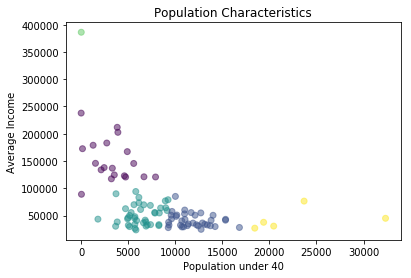

In [134]:

%matplotlib inline
import matplotlib.pyplot as plt

plt.title("Population Characteristics")
plt.scatter(X[:, 1], X[:, 0], c=labels.astype(np.float), alpha=0.5)
plt.xlabel('Population under 40', fontsize=10)
plt.ylabel('Average Income', fontsize=10)

plt.show()


In [74]:
# Install folium

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::anaconda==5.3.1=py37_0
  - defaults/linux-64::astropy==3.0.4=py37h14c3975_0
  - defaults/linux-64::bkcharts==0.2=py37_0
  - defaults/linux-64::blaze==0.11.3=py37_0
  - defaults/linux-64::bokeh==0.13.0=py37_0
  - defaults/linux-64::bottleneck==1.2.1=py37h035aef0_1
  - defaults/linux-64::dask==0.19.1=py37_0
  - defaults/linux-64::datashape==0.5.4=py37_1
  - defaults/linux-64::mkl-service==1.1.2=py37h90e4bf4_5
  - defaults/linux-64::numba==0.39.0=py37h04863e7_0
  - defaults/linux-64::numexpr==2.6.8=py37hd89afb7_0
  - defaults/linux-64::odo==0.5.1=py37_0
  - defaults/linux-64::pytables==3.4.4=py37ha205bf6_0
  - defaults/linux-64::pytest-arraydiff==0.2=py37h39e3cac_0
  - defaults/linux-64::pytest-astropy==0.4.0=py37_0
  - defaults/linux-64::pytest-doctestplus==0.1.3=py37_0
  - defaults/linux-64::pywavelets==1.0.0=py37h

In [147]:
# create map
latitude = 43.6529
longitude = -79.3849
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(clusterNum)
ys = [i + x + (i*x)**2 for i in range(clusterNum)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Merge_table1['Latitude'], Merge_table1['Longitude'], Merge_table1['Neighbourhood'], Merge_table1['Clus_km']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [162]:
Merge_table2 = Merge_table1.join(Coffeevenue_agg.set_index('Neighbourhood'), on='Neighbourhood')
Merge_table2['Coffee Shop'] = Merge_table2['Coffee Shop'].fillna(0.0)
Merge_table2['Chocolate Shop'] = Merge_table2['Chocolate Shop'].fillna(0.0)
Merge_table2['Dessert Shop'] = Merge_table2['Dessert Shop'].fillna(0.0)
Merge_table2['Number of Coffee Venues'] = Merge_table2['Number of Coffee Venues'].fillna(0.0)
Merge_table3 = Merge_table2.sort_values(['Number of Coffee Venues'],ascending=[0])
Merge_table3


,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Average Income,Population under 40,Clus_km,Coffee Shop,Chocolate Shop,Dessert Shop,Café,Number of Coffee Venues
42,M5K,Downtown Toronto,"Design Exchange, Toronto Dominion Centre",43.647177,-79.381576,172630.555556,150.0,0,13.0,0.0,0.0,8.0,21.0
48,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,237900.000000,10.0,0,13.0,0.0,0.0,7.0,20.0
24,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,26468.434604,5720.0,2,13.0,0.0,1.0,5.0,19.0
36,M5J,Downtown Toronto,"Harbourfront East, Toronto Islands, Union Station",43.640816,-79.381752,94132.249071,5810.0,2,13.0,0.0,0.0,4.0,17.0
92,M5W,Downtown Toronto,Stn A PO Boxes 25 The Esplanade,43.646435,-79.374846,89029.411765,40.0,0,11.0,0.0,0.0,4.0,15.0
97,M5X,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,386127.272727,20.0,3,8.0,0.0,0.0,7.0,15.0
84,M5T,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",43.653206,-79.400049,36766.070150,6630.0,2,4.0,0.0,2.0,8.0,14.0
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,145786.910995,1530.0,0,8.0,0.0,0.0,5.0,13.0
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636,50511.195010,14020.0,1,7.0,1.0,1.0,3.0,12.0
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,46121.436004,4990.0,2,6.0,0.0,1.0,4.0,11.0


# 4. Discussions

### Cluster 1

In [173]:
Cluster1 = Merge_table3[Merge_table3['Clus_km']==0]
Cluster1.to_csv("cluster1.csv")
Cluster1


,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Average Income,Population under 40,Clus_km,Coffee Shop,Chocolate Shop,Dessert Shop,Café,Number of Coffee Venues
42,M5K,Downtown Toronto,"Design Exchange, Toronto Dominion Centre",43.647177,-79.381576,172630.555556,150.0,0,13.0,0.0,0.0,8.0,21.0
48,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,237900.000000,10.0,0,13.0,0.0,0.0,7.0,20.0
92,M5W,Downtown Toronto,Stn A PO Boxes 25 The Esplanade,43.646435,-79.374846,89029.411765,40.0,0,11.0,0.0,0.0,4.0,15.0
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,145786.910995,1530.0,0,8.0,0.0,0.0,5.0,13.0
30,M5H,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568,178935.887097,1280.0,0,6.0,0.0,0.0,5.0,11.0
74,M5R,Central Toronto,"The Annex, North Midtown, Yorkville",43.672710,-79.405678,120758.478931,7910.0,0,3.0,0.0,0.0,3.0,6.0
23,M4G,East York,Leaside,43.709060,-79.363452,122920.000000,4600.0,0,3.0,0.0,1.0,0.0,4.0
55,M5M,North York,"Bedford Park, Lawrence Manor East",43.733283,-79.419750,121093.922652,6680.0,0,2.0,0.0,0.0,1.0,3.0
73,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,136834.637514,3320.0,0,2.0,0.0,1.0,0.0,3.0
86,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049,167263.311920,4910.0,0,2.0,0.0,0.0,0.0,2.0


In [164]:
print("Average Income range is: ", Cluster1['Average Income'].min().round(2), "to", Cluster1['Average Income'].max().round(2))
print("Average Population under 40 in each neighbourhood is ", Cluster1['Population under 40'].mean() )

Average Income range is:  89029.41 to 237900.0
Average Population under 40 in each neighbourhood is  3292.6315789473683


### Cluster 2

In [165]:
Cluster2 = Merge_table3[Merge_table3['Clus_km']==1]
Cluster2

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Average Income,Population under 40,Clus_km,Coffee Shop,Chocolate Shop,Dessert Shop,Café,Number of Coffee Venues
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636,50511.195010,14020.0,1,7.0,1.0,1.0,3.0,12.0
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,50632.030209,12110.0,1,6.0,0.0,0.0,2.0,8.0
37,M6J,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750,55496.208930,11690.0,1,3.0,0.0,0.0,2.0,5.0
43,M6K,West Toronto,"Brockton, Exhibition Place, Parkdale Village",43.636847,-79.428191,43113.466163,15350.0,1,2.0,0.0,0.0,2.0,4.0
25,M6G,Downtown Toronto,Christie,43.669542,-79.422564,57558.071368,9660.0,1,1.0,0.0,0.0,3.0,4.0
13,M3C,North York,"Flemingdon Park, Don Mills South",43.725900,-79.340923,42811.455211,11040.0,1,2.0,0.0,0.0,1.0,3.0
69,M6P,West Toronto,"High Park, The Junction South",43.661608,-79.464763,54895.310391,12720.0,1,0.0,0.0,0.0,2.0,2.0
28,M3H,North York,"Bathurst Manor, Downsview North, Wilson Heights",43.754328,-79.442259,60156.550294,11010.0,1,2.0,0.0,0.0,0.0,2.0
22,M1G,Scarborough,Woburn,43.770992,-79.216917,27923.137599,9260.0,1,2.0,0.0,0.0,0.0,2.0
72,M2R,North York,Willowdale West,43.782736,-79.442259,36254.788023,11890.0,1,1.0,0.0,0.0,0.0,1.0


In [166]:
print("Average Income range is: ", Cluster2['Average Income'].min().round(2), "to", Cluster2['Average Income'].max().round(2))
print("Average Population under 40 in each neighbourhood is ", Cluster2['Population under 40'].mean() )

Average Income range is:  24784.61 to 85128.79
Average Population under 40 in each neighbourhood is  11835.714285714286


### Cluster 3

In [167]:
Cluster3 = Merge_table3[Merge_table3['Clus_km']==2]
Cluster3

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Average Income,Population under 40,Clus_km,Coffee Shop,Chocolate Shop,Dessert Shop,Café,Number of Coffee Venues
24,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,26468.434604,5720.0,2,13.0,0.0,1.0,5.0,19.0
36,M5J,Downtown Toronto,"Harbourfront East, Toronto Islands, Union Station",43.640816,-79.381752,94132.249071,5810.0,2,13.0,0.0,0.0,4.0,17.0
84,M5T,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",43.653206,-79.400049,36766.070150,6630.0,2,4.0,0.0,2.0,8.0,14.0
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,46121.436004,4990.0,2,6.0,0.0,1.0,4.0,11.0
81,M6S,West Toronto,"Runnymede, Swansea",43.651571,-79.484450,79046.268657,9240.0,2,4.0,0.0,1.0,3.0,8.0
80,M5S,Downtown Toronto,"Harbord, University of Toronto",43.662696,-79.400049,73415.477214,6140.0,2,1.0,0.0,1.0,5.0,7.0
79,M4S,Central Toronto,Davisville,43.704324,-79.388790,76960.791016,8950.0,2,2.0,0.0,3.0,2.0,7.0
54,M4M,East Toronto,Studio District,43.659526,-79.340923,54544.167119,7850.0,2,3.0,0.0,0.0,4.0,7.0
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,89985.552408,3710.0,2,5.0,0.0,0.0,2.0,7.0
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,63847.615063,8450.0,2,4.0,0.0,1.0,1.0,6.0


In [168]:
print("Average Income range is: ", Cluster3['Average Income'].min().round(2), "to", Cluster3['Average Income'].max().round(2))
print("Average Population under 40 in each neighbourhood is ", Cluster3['Population under 40'].mean() )

Average Income range is:  23701.22 to 94132.25
Average Population under 40 in each neighbourhood is  6345.75


### Cluster 4

In [169]:
Cluster4 = Merge_table3[Merge_table3['Clus_km']==3]
Cluster4


,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Average Income,Population under 40,Clus_km,Coffee Shop,Chocolate Shop,Dessert Shop,Café,Number of Coffee Venues
97,M5X,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.38228,386127.272727,20.0,3,8.0,0.0,0.0,7.0,15.0


In [170]:
print("Average Income range is: ", Cluster4['Average Income'].min().round(2), "to", Cluster4['Average Income'].max().round(2))
print("Average Population under 40 in each neighbourhood is ", Cluster4['Population under 40'].mean() )

Average Income range is:  386127.27 to 386127.27
Average Population under 40 in each neighbourhood is  20.0


### Cluster 5

In [171]:
Cluster5 = Merge_table3[Merge_table3['Clus_km']==4]
Cluster5


,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Average Income,Population under 40,Clus_km,Coffee Shop,Chocolate Shop,Dessert Shop,Café,Number of Coffee Venues
59,M2N,North York,Willowdale South,43.770120,-79.408493,44988.496198,32340.0,4,3.0,0.0,0.0,2.0,5.0
33,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,37688.863255,19390.0,4,4.0,0.0,0.0,0.0,4.0
87,M5V,Downtown Toronto,"CN Tower, Bathurst Quay, Island airport, Harbo...",43.628947,-79.394420,76540.548258,23690.0,4,0.0,0.0,0.0,0.0,0.0
89,M9V,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ...",43.739416,-79.588437,26914.854234,18450.0,4,0.0,0.0,0.0,0.0,0.0
6,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,30679.498152,20460.0,4,0.0,0.0,0.0,0.0,0.0


In [172]:
print("Average Income range is: ", Cluster5['Average Income'].min().round(2), "to", Cluster5['Average Income'].max().round(2))
print("Average Population under 40 in each neighbourhood is ", Cluster5['Population under 40'].mean() )

Average Income range is:  26914.85 to 76540.55
Average Population under 40 in each neighbourhood is  22866.0


#### The best suited cluster is Cluster 1. There is also a decent Population under 40 in most of these neighbourhoods giving a good potential customer base.  However, it should be noted that a few neighbourhoods, especially those in the Downtown Toronto area, seem to have a number of existing coffee-related venues already, pointing to potential competitions. The client may want to avoid these neighbourhoods as a result.  Other clusters contain neighbourhoods that fit to a lesser extent the criteria of the business.  One of the clusters has actually been captured as an outlier and should be ignored.   


# 5. Conclusions

Using a combination of statistics and machine learning tools, we are able to address the client’s problem and arrive at a list of suggested neighbourhoods that are suitable location candidates for her future gourmet coffee shop business